In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# GPU check
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [3]:
# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from pycaret.regression import RegressionExperiment

from post_process import (
    extract_probs,
)

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
n_qubits = 12
n_samples = 55
backend_qpu_name = "ibm_marrakesh"

if n_qubits <= 12:
    path_exact = f"results/fourier_feature_exact/{n_qubits}Q"
    path_sim_noisy = f"results/fourier_feature_sim_noisy/{n_qubits}Q"
path_sim_noiseless = f"results/fourier_feature_sim_noiseless/{n_qubits}Q"
path_qpu = f"results/fourier_feature_qpu/{n_qubits}Q"

## Plot probability

In [7]:
# Load the data as a json file
if n_qubits <= 12:
    with open(f"{path_exact}/probs_phase0.json", "r") as f:
        probs_phase0_exact = json.load(f)
    with open(f"{path_exact}/probs_phase1.json", "r") as f:
        probs_phase1_exact = json.load(f)
    with open(f"{path_exact}/probs_phase2.json", "r") as f:
        probs_phase2_exact = json.load(f)
    with open(f"{path_exact}/probs_phase3.json", "r") as f:
        probs_phase3_exact = json.load(f)

    with open(f"{path_sim_noisy}/probs_phase0.json", "r") as f:
        probs_phase0_sim_noisy = json.load(f)
    with open(f"{path_sim_noisy}/probs_phase1.json", "r") as f:
        probs_phase1_sim_noisy = json.load(f)
    with open(f"{path_sim_noisy}/probs_phase2.json", "r") as f:
        probs_phase2_sim_noisy = json.load(f)
    with open(f"{path_sim_noisy}/probs_phase3.json", "r") as f:
        probs_phase3_sim_noisy = json.load(f)

with open(f"{path_sim_noiseless}/probs_phase0.json", "r") as f:
    probs_phase0_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase1.json", "r") as f:
    probs_phase1_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase2.json", "r") as f:
    probs_phase2_sim_noiseless = json.load(f)
with open(f"{path_sim_noiseless}/probs_phase3.json", "r") as f:
    probs_phase3_sim_noiseless = json.load(f)

with open(f"{path_qpu}/probs_phase0.json", "r") as f:
    probs_phase0_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase1.json", "r") as f:
    probs_phase1_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase2.json", "r") as f:
    probs_phase2_qpu = json.load(f)
with open(f"{path_qpu}/probs_phase3.json", "r") as f:
    probs_phase3_qpu = json.load(f)

In [8]:
# Dummy data
# probs_phase0_qpu = probs_phase0_exact
# probs_phase1_qpu = probs_phase1_exact
# probs_phase2_qpu = probs_phase2_exact
# probs_phase3_qpu = probs_phase3_exact

In [9]:
if n_qubits <= 12:
    probs_phase0_exact = extract_probs(probs_phase0_exact, probs_phase0_qpu)
    probs_phase1_exact = extract_probs(probs_phase1_exact, probs_phase1_qpu)
    probs_phase2_exact = extract_probs(probs_phase2_exact, probs_phase2_qpu)
    probs_phase3_exact = extract_probs(probs_phase3_exact, probs_phase3_qpu)

    probs_phase0_sim_noisy = extract_probs(probs_phase0_sim_noisy, probs_phase0_qpu)
    probs_phase1_sim_noisy = extract_probs(probs_phase1_sim_noisy, probs_phase1_qpu)
    probs_phase2_sim_noisy = extract_probs(probs_phase2_sim_noisy, probs_phase2_qpu)
    probs_phase3_sim_noisy = extract_probs(probs_phase3_sim_noisy, probs_phase3_qpu)

probs_phase0_sim_noiseless = extract_probs(probs_phase0_sim_noiseless, probs_phase0_qpu)
probs_phase1_sim_noiseless = extract_probs(probs_phase1_sim_noiseless, probs_phase1_qpu)
probs_phase2_sim_noiseless = extract_probs(probs_phase2_sim_noiseless, probs_phase2_qpu)
probs_phase3_sim_noiseless = extract_probs(probs_phase3_sim_noiseless, probs_phase3_qpu)

probs_phase0_qpu = extract_probs(probs_phase0_qpu, probs_phase0_qpu)
probs_phase1_qpu = extract_probs(probs_phase1_qpu, probs_phase1_qpu)
probs_phase2_qpu = extract_probs(probs_phase2_qpu, probs_phase2_qpu)
probs_phase3_qpu = extract_probs(probs_phase3_qpu, probs_phase3_qpu)

## Plot exact vs. Trotterized results (only for <= 12 qubits)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

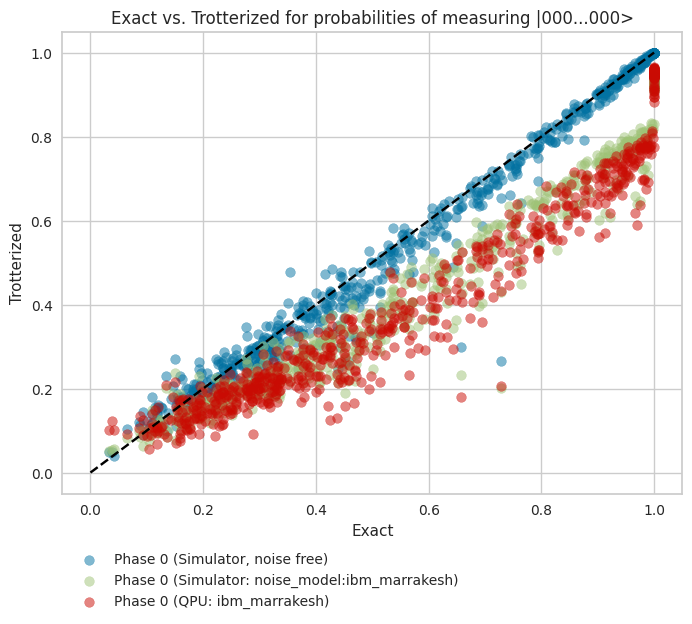

In [10]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim_noiseless,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_sim_noisy,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact,
    probs_phase0_qpu,
    label=f"Phase 0 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

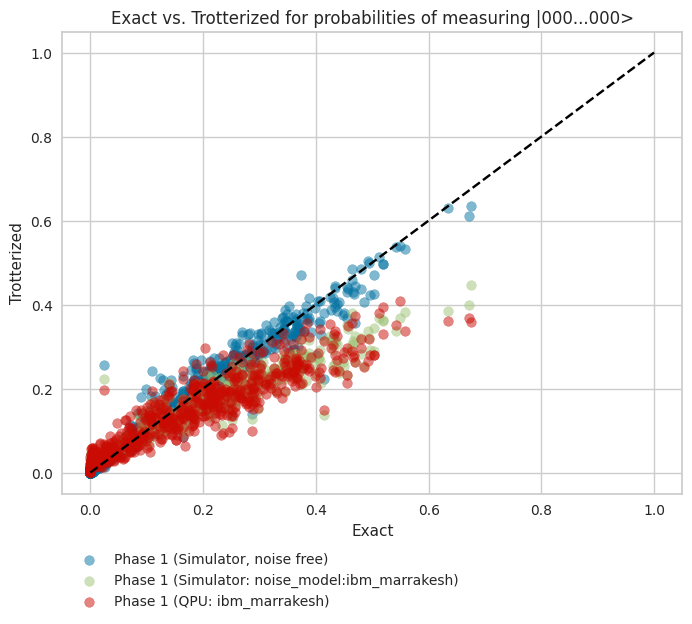

In [11]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim_noiseless,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_sim_noisy,
    label=f"Phase 1 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact,
    probs_phase1_qpu,
    label=f"Phase 1 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

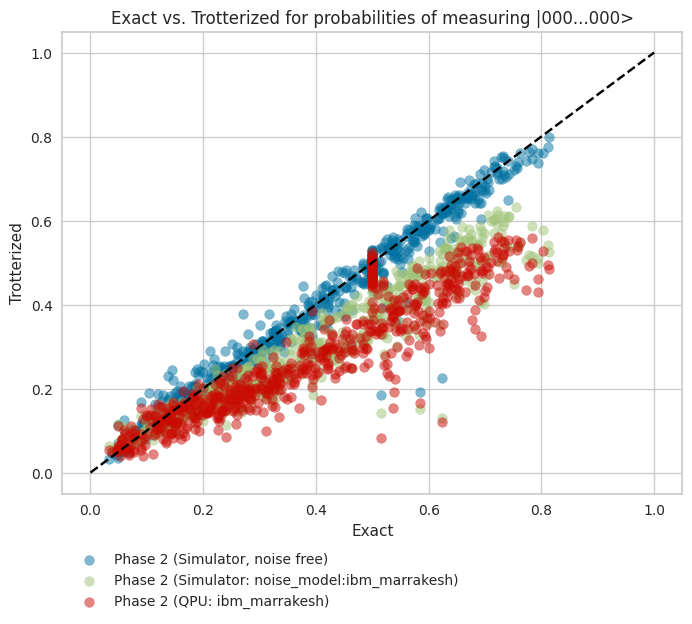

In [12]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim_noiseless,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_sim_noisy,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact,
    probs_phase2_qpu,
    label=f"Phase 2 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

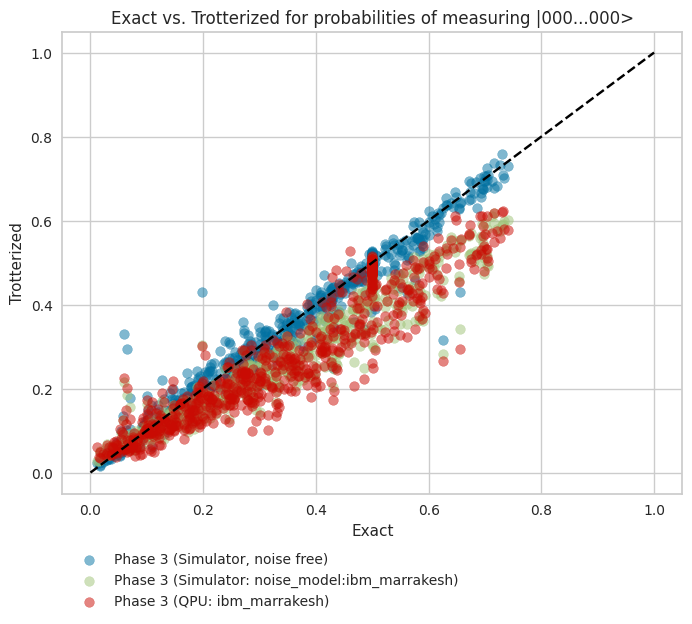

In [13]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim_noiseless,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_sim_noisy,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact,
    probs_phase3_qpu,
    label=f"Phase 3 (QPU: {backend_qpu_name})",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Plot exact vs. Simulator results

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

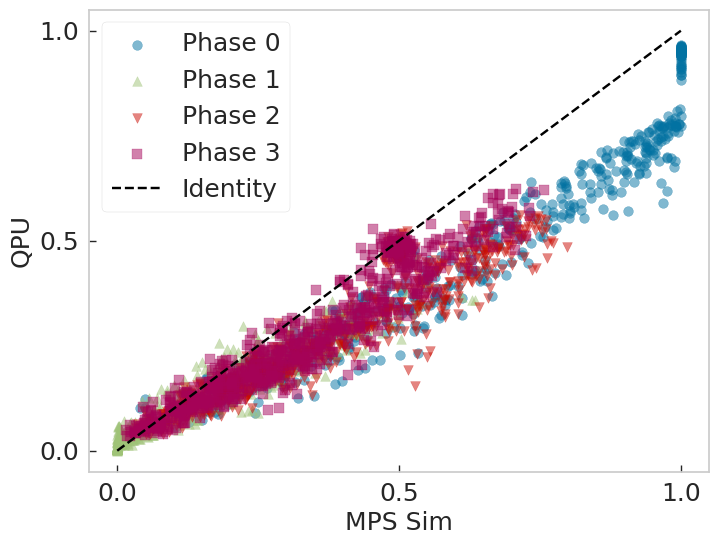

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_sim_noiseless,
    probs_phase0_qpu,
    label=f"Phase 0",
    alpha=0.5,
    marker="o",
)
plt.scatter(
    probs_phase1_sim_noiseless,
    probs_phase1_qpu,
    label=f"Phase 1",
    alpha=0.5,
    marker="^",
)
plt.scatter(
    probs_phase2_sim_noiseless,
    probs_phase2_qpu,
    label=f"Phase 2",
    alpha=0.5,
    marker="v",
)
plt.scatter(
    probs_phase3_sim_noiseless,
    probs_phase3_qpu,
    label=f"Phase 3",
    alpha=0.5,
    marker="s",
)

# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black", label="Identity")
plt.xlabel("MPS Sim", fontsize=18)
plt.ylabel("QPU", fontsize=18)
plt.legend(fontsize=18, frameon=True)

# 目盛の設定
ax = plt.gca()  # 現在のAxesを取得
major_ticks = [0, 0.5, 1.0]
ax.set_xticks(major_ticks, minor=False)
ax.set_yticks(major_ticks, minor=False)
ax.tick_params(direction="in", which="major", length=5, labelsize=18)
ax.minorticks_on()  # 補助目盛をオンにする

plt.grid(False)

# plt.title(
#     f"Sim vs. QPU for probabilities of measuring |000...000> for {n_qubits} qubits"
# )

plt.savefig(
    f"results/regression/{n_qubits}Q/prob_sim_vs_qpu.pdf",
    bbox_inches="tight",
)
plt.show()

## Regression

In [15]:
if n_qubits <= 12:
    feature_exact_df = pd.read_json(f"{path_exact}/features.json")
    feature_sim_noisy_df = pd.read_json(f"{path_sim_noisy}/features.json")

feature_sim_noiseless_df = pd.read_json(f"{path_sim_noiseless}/features.json")
feature_qpu_df = pd.read_json(f"{path_qpu}/features.json")

## Feature check

In [16]:
# only for n_qubits <= 12
print("Exact")
display(feature_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,f_10 Re,f_10 Im,f_11 Re,f_11 Im,expected_value
0,0,1,0.884346,-0.290790,0.590681,-0.455664,0.249620,-0.436470,-0.000841,-0.271373,...,0.009273,0.152261,-0.166732,0.070729,-0.392707,-0.143031,-0.553603,-0.408317,-0.568128,0.792109
1,1,1,0.958672,0.058620,0.843443,0.094560,0.675717,0.094943,0.479441,0.058950,...,-0.201326,-0.248002,-0.311919,-0.351952,-0.415939,-0.412986,-0.501580,-0.434392,-0.561235,1.102887
2,2,1,0.969004,0.096452,0.886165,0.168408,0.775616,0.204301,0.661830,0.208788,...,0.159172,0.323352,0.141019,0.262000,0.120255,0.210733,0.096192,0.170814,0.070829,1.130663
3,3,1,0.840284,0.325383,0.476275,0.453387,0.150224,0.358141,0.024002,0.189338,...,0.231905,0.092290,0.220071,0.096749,0.139732,0.156661,0.087465,0.189922,0.117921,1.552866
4,4,1,0.968924,0.122170,0.881160,0.233715,0.750980,0.323699,0.596444,0.381772,...,0.317099,0.023414,0.228696,-0.061265,0.124162,-0.111326,0.015031,-0.126893,-0.089063,1.149036
5,5,1,0.923418,0.235336,0.729782,0.377633,0.508328,0.380620,0.354834,0.267509,...,0.040066,0.576953,0.159808,0.531476,0.315011,0.379545,0.417652,0.182884,0.406051,1.332599
6,6,1,0.877220,0.012721,0.579644,0.070750,0.252072,0.141108,-0.011120,0.139174,...,-0.208172,-0.466443,-0.197567,-0.340189,-0.136247,-0.170852,-0.086931,-0.053671,-0.056556,1.114135
7,7,1,0.919059,-0.036902,0.713936,-0.046552,0.472372,-0.026207,0.276543,0.000777,...,-0.049324,0.016012,-0.063564,-0.046470,-0.039144,-0.103412,0.021718,-0.133714,0.097630,1.034106
8,8,1,0.899118,0.287753,0.650736,0.447320,0.382226,0.426871,0.214108,0.274517,...,-0.010753,0.461227,0.067963,0.462037,0.175611,0.407795,0.272868,0.322557,0.345102,1.421492
9,9,1,0.865913,-0.464001,0.519866,-0.774628,0.095855,-0.855118,-0.270517,-0.728487,...,0.063439,-0.436205,0.269667,-0.250622,0.398224,-0.036802,0.427247,0.153570,0.351521,0.634733


In [17]:
print("Simulator (noise free)")
display(feature_sim_noiseless_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,f_10 Re,f_10 Im,f_11 Re,f_11 Im,expected_value
0,0,1,0.876077,-0.277586,0.566648,-0.460112,0.313325,-0.383469,0.044098,-0.233093,...,-0.001500,0.083436,-0.142998,0.027928,-0.354024,-0.099377,-0.475559,-0.290284,-0.508708,0.792109
1,1,1,0.961156,0.060720,0.807814,0.117499,0.643257,0.129190,0.459148,0.117911,...,-0.151477,-0.207359,-0.262626,-0.336024,-0.421669,-0.377320,-0.487814,-0.377292,-0.555319,1.102887
2,2,1,0.977192,0.122331,0.882960,0.177472,0.749348,0.245558,0.599896,0.243739,...,0.190575,0.216572,0.156786,0.262155,0.156681,0.158898,0.117980,0.135672,0.107359,1.130663
3,3,1,0.838372,0.328422,0.498865,0.402542,0.111033,0.282086,0.005683,0.048833,...,0.116560,0.037455,0.035314,0.135668,0.029089,0.241459,0.013092,0.392408,0.074462,1.552866
4,4,1,0.974972,0.113246,0.882893,0.212445,0.732779,0.292554,0.617651,0.346622,...,0.362340,0.140335,0.330283,-0.035514,0.226920,-0.094289,0.114763,-0.138224,0.080617,1.149036
5,5,1,0.910278,0.242566,0.723908,0.402644,0.436203,0.429196,0.198462,0.244871,...,-0.086538,0.589159,-0.035612,0.561372,0.251678,0.459486,0.341311,0.192999,0.390554,1.332599
6,6,1,0.896347,-0.010863,0.547428,-0.016236,0.202588,-0.025103,0.008705,-0.002286,...,-0.262727,-0.300876,-0.276895,-0.352995,-0.061052,-0.224430,0.020474,-0.052865,0.008848,1.114135
7,7,1,0.928492,-0.045633,0.685381,-0.060259,0.405999,-0.039976,0.156939,0.011143,...,-0.019622,-0.034892,-0.038827,-0.055936,-0.044645,-0.087525,-0.047555,-0.143228,0.053737,1.034106
8,8,1,0.893531,0.287058,0.602000,0.446839,0.325641,0.414258,0.072166,0.252510,...,0.006887,0.466211,0.095396,0.477843,0.186231,0.428424,0.281452,0.311454,0.320102,1.421492
9,9,1,0.861970,-0.457988,0.564329,-0.744691,0.074170,-0.864384,-0.298457,-0.684237,...,0.098971,-0.329169,0.262536,-0.237393,0.388007,-0.025972,0.366266,0.154751,0.355877,0.634733


In [18]:
# only for n_qubits <= 12
print("Simulator (noisy)")
display(feature_sim_noisy_df)

Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,f_10 Re,f_10 Im,f_11 Re,f_11 Im,expected_value
0,0,0.937500,0.689587,-0.229130,0.469491,-0.368162,0.239895,-0.325551,0.094243,-0.163047,...,0.003858,0.059508,-0.077585,0.030263,-0.217255,-0.080562,-0.307849,-0.176784,-0.309825,0.792109
1,1,0.909180,0.755348,0.027183,0.667724,0.102088,0.535889,0.113561,0.343682,0.059963,...,-0.100874,-0.128379,-0.179023,-0.208711,-0.248033,-0.204621,-0.273028,-0.224936,-0.299190,1.102887
2,2,0.934570,0.773981,0.071705,0.714103,0.145320,0.610827,0.176676,0.467015,0.215232,...,0.110241,0.170245,0.106771,0.136615,0.035690,0.107147,0.067460,0.103760,0.065364,1.130663
3,3,0.919922,0.670222,0.245851,0.388215,0.339756,0.100387,0.256384,0.010913,0.039646,...,0.055958,0.041757,0.054545,0.121835,0.049488,0.159579,-0.005038,0.237930,0.077200,1.552866
4,4,0.922852,0.766576,0.100779,0.723552,0.160521,0.567209,0.230897,0.472385,0.269031,...,0.259081,0.085471,0.231618,-0.002232,0.123042,-0.082262,0.091590,-0.109548,0.062197,1.149036
5,5,0.913086,0.771073,0.207380,0.547459,0.325024,0.340856,0.341366,0.146112,0.237335,...,-0.096845,0.415100,-0.027654,0.339135,0.146516,0.278014,0.252555,0.132041,0.240608,1.332599
6,6,0.921875,0.686513,0.044433,0.466333,-0.003102,0.170926,-0.003787,-0.006125,0.022812,...,-0.180514,-0.185450,-0.175690,-0.210936,-0.050409,-0.103547,0.021334,-0.028725,0.016335,1.114135
7,7,0.910156,0.727865,-0.015345,0.553081,-0.041577,0.332008,-0.034057,0.074568,-0.024754,...,0.014798,0.032088,0.010350,-0.032437,-0.031215,-0.088108,-0.010192,-0.104024,0.026047,1.034106
8,8,0.919922,0.718727,0.226182,0.518480,0.352052,0.270094,0.330352,0.056931,0.248459,...,-0.015929,0.330963,0.055069,0.276631,0.085838,0.235371,0.133795,0.206065,0.207343,1.421492
9,9,0.917969,0.662896,-0.391488,0.405867,-0.628189,0.081692,-0.658197,-0.233871,-0.569205,...,0.065036,-0.282381,0.206357,-0.167096,0.219452,0.033685,0.241073,0.133769,0.183548,0.634733


In [19]:
print("QPU")
display(feature_qpu_df)

QPU


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,f_10 Re,f_10 Im,f_11 Re,f_11 Im,expected_value
0,0,0.894,0.608061,-0.269830,0.393699,-0.335748,0.154253,-0.273774,0.081963,-0.136081,...,-0.050146,0.059641,-0.077923,-0.081465,-0.208085,-0.179955,-0.198950,-0.281172,-0.168140,0.792109
1,1,0.904,0.702251,-0.051360,0.598211,0.035118,0.508561,0.114587,0.336921,0.067705,...,-0.098856,-0.130094,-0.169244,-0.146314,-0.252769,-0.156456,-0.278579,-0.177029,-0.337412,1.102887
2,2,0.876,0.738979,0.059056,0.640933,0.145929,0.527899,0.188826,0.430923,0.157639,...,0.104131,0.182071,0.085880,0.179083,0.108638,0.140444,0.103371,0.127039,0.067831,1.130663
3,3,0.919,0.657926,0.043011,0.407268,0.252442,0.159709,0.168884,-0.013340,0.050597,...,0.052190,0.025068,0.052389,0.083327,0.023763,0.176146,-0.002372,0.221758,0.118829,1.552866
4,4,0.908,0.728017,-0.068817,0.644951,0.097325,0.540864,0.180409,0.438869,0.130442,...,0.206299,0.090603,0.197183,-0.072240,0.105837,-0.076163,0.064808,-0.083124,0.044770,1.149036
5,5,0.903,0.686750,0.204094,0.541424,0.277857,0.324335,0.319512,0.140685,0.193230,...,-0.143934,0.363322,-0.056195,0.363176,0.137699,0.269235,0.210220,0.149341,0.221678,1.332599
6,6,0.916,0.631380,-0.065393,0.414109,-0.072627,0.137418,-0.026801,0.003400,0.020819,...,-0.148042,-0.195260,-0.152772,-0.202358,0.072864,-0.107078,0.053844,-0.009398,0.017311,1.114135
7,7,0.889,0.645722,-0.090909,0.507925,-0.092032,0.260203,-0.004854,0.074223,0.004002,...,0.031565,-0.004106,0.003484,0.001832,-0.016451,-0.097754,-0.008371,-0.132881,0.032596,1.034106
8,8,0.894,0.642764,0.133629,0.503196,0.263171,0.283667,0.310536,0.089760,0.211724,...,-0.082219,0.267951,-0.022345,0.289722,0.040576,0.233645,0.086552,0.242579,0.126824,1.421492
9,9,0.908,0.543202,-0.408726,0.362215,-0.554823,0.036693,-0.594970,-0.208842,-0.505625,...,0.148678,-0.160398,0.207712,-0.019776,0.245695,0.061629,0.223801,0.186722,0.143832,0.634733


## Regression

In [20]:
# setup
train_size = 0.8
session_id = 42
sort = "MSE"

### Regression with features from exact (Diagonization) (only for <= 12 qubits)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0130
huber,Huber Regressor,0.0062,0.0004,0.0107,0.9972,0.0046,0.0053,0.0300
ridge,Ridge Regression,0.0371,0.0053,0.0547,0.9630,0.0239,0.0332,0.0130
dt,Decision Tree Regressor,0.0551,0.0059,0.0697,0.9563,0.0300,0.0476,0.0130
gbr,Gradient Boosting Regressor,0.0426,0.0060,0.0569,0.9629,0.0241,0.0356,0.0620
et,Extra Trees Regressor,0.0380,0.0068,0.0552,0.9603,0.0230,0.0308,0.1720
par,Passive Aggressive Regressor,0.0618,0.0087,0.0792,0.9423,0.0326,0.0519,0.0130
rf,Random Forest Regressor,0.0532,0.0087,0.0720,0.9474,0.0311,0.0460,0.2410
ada,AdaBoost Regressor,0.0587,0.0102,0.0796,0.9377,0.0339,0.0487,0.0650
knn,K Neighbors Regressor,0.0789,0.0152,0.1036,0.9016,0.0467,0.0751,0.0400


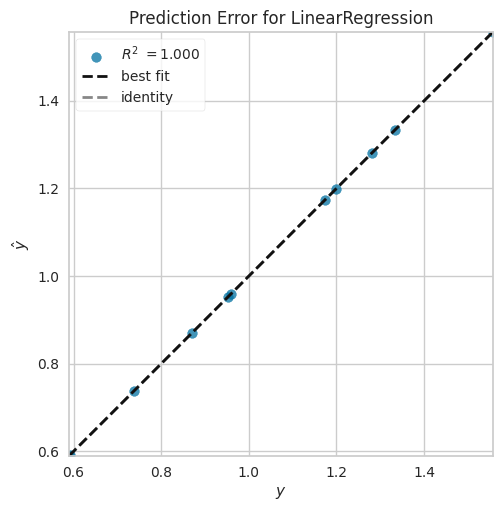

In [21]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=feature_exact_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # Use GPU
)

best_exact = s_exact.compare_models(turbo=True, sort=sort)
s_exact.plot_model(best_exact, plot="error")

### Regression with features from noiseless simulation

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0187,0.0007,0.0242,0.9937,0.0103,0.0159,0.0130
huber,Huber Regressor,0.0201,0.0008,0.0256,0.9931,0.0109,0.0167,0.0280
lr,Linear Regression,0.0223,0.0010,0.0285,0.9908,0.0121,0.0185,0.0120
gbr,Gradient Boosting Regressor,0.0386,0.0045,0.0514,0.9674,0.0224,0.0334,0.0620
et,Extra Trees Regressor,0.0337,0.0047,0.0463,0.9709,0.0188,0.0263,0.1740
ridge,Ridge Regression,0.0413,0.0056,0.0581,0.9576,0.0253,0.0363,0.0120
par,Passive Aggressive Regressor,0.0686,0.0083,0.0832,0.9310,0.0358,0.0609,0.0120
dt,Decision Tree Regressor,0.0678,0.0083,0.0846,0.9232,0.0354,0.0560,0.0130
rf,Random Forest Regressor,0.0525,0.0085,0.0727,0.9440,0.0315,0.0445,0.2370
ada,AdaBoost Regressor,0.0663,0.0110,0.0877,0.9234,0.0373,0.0547,0.0650


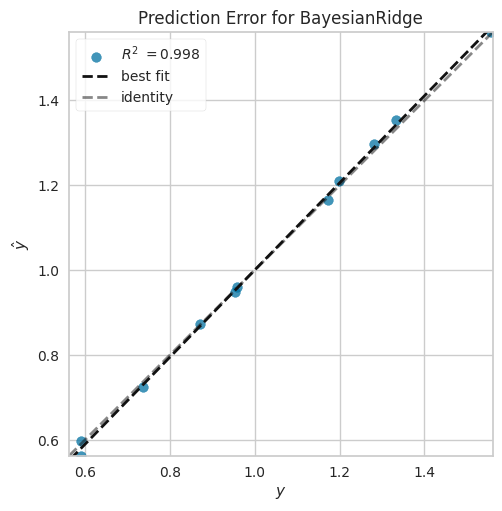

In [22]:
s_sim_noiseless = RegressionExperiment()
s_sim_noiseless.setup(
    data=feature_sim_noiseless_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # only for GPU
)

best_sim_noiseless = s_sim_noiseless.compare_models(turbo=True, sort=sort)
s_sim_noiseless.plot_model(best_sim_noiseless, plot="error")

In [23]:
# helper function
def create_model_and_plot(
    experiment: RegressionExperiment,
    exact_experiment: RegressionExperiment = None,  # 比較用: 厳密対角化の結果
    sim_noiseless_experiment: RegressionExperiment = None,  # 比較用: MPS シミュレータのノイズなしの結果
    reg_method=None,  # 回帰手法. "ada", "dt", "et", "gbr", "knn", "lar", "lightgbm", "lr", "mlp", "omp", "par", "ransac", "rf", "ridge", "svm", "xgboost"
    is_qpu=False,  # QPU の結果かどうか
) -> None:
    # モデルを作成
    if reg_method:  # 指定された回帰手法でモデルを作成
        model = experiment.create_model(reg_method, verbose=False)
        sim_model = sim_noiseless_experiment.create_model(reg_method, verbose=False)
    else:  # 指定されなければ最適なモデルを作成
        model = experiment.compare_models(turbo=True, sort=sort, verbose=False)
        sim_model = sim_noiseless_experiment.compare_models(
            turbo=True, sort=sort, verbose=False
        )

    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        # exact は最適なモデル (おそらく線形回帰) を作成
        exact_model = exact_experiment.compare_models(
            turbo=True, sort=sort, verbose=False
        )
        # ハイパーパラメータのチューニング
        # exact_experiment.tune_model(
        #     exact_model, optimize=sort, choose_better=True, verbose=False
        # )

    # experiment.tune_model(model, optimize=sort, choose_better=True, verbose=True)

    # 回帰手法の名前を取得
    reg_method = model.__class__.__name__
    sim_reg_method = sim_model.__class__.__name__
    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_reg_method = exact_model.__class__.__name__

    # 予測
    device = "QPU" if is_qpu else "noisy Sim"
    pred = experiment.predict_model(model)
    x = pred["expected_value"].values.reshape(-1, 1)  # サンプル数 x 1
    y = pred["prediction_label"].values
    r2 = r2_score(x, y)
    mse = mean_squared_error(x, y)
    print(f"({device}) {n_qubits} qubits: {reg_method}, R2 = {r2:.2e}, MSE = {mse:.2e}")

    sim_pred = sim_noiseless_experiment.predict_model(sim_model)
    sim_x = sim_pred["expected_value"].values.reshape(-1, 1)
    sim_y = sim_pred["prediction_label"].values
    sim_r2 = r2_score(sim_x, sim_y)
    sim_mse = mean_squared_error(sim_x, sim_y)
    print(
        f"(Sim, noise free) {n_qubits} qubits: {sim_reg_method}, R2 = {sim_r2:.2e}, MSE = {sim_mse:.2e}"
    )

    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_pred = exact_experiment.predict_model(exact_model)
        exact_x = exact_pred["expected_value"].values.reshape(-1, 1)
        exact_y = exact_pred["prediction_label"].values
        exact_r2 = r2_score(exact_x, exact_y)
        exact_mse = mean_squared_error(exact_x, exact_y)
        print(
            f"(Exact) {n_qubits} qubits: {exact_reg_method}, R2 = {exact_r2:.2e}, MSE = {exact_mse:.2e}"
        )

    # 回帰直線を計算
    linear_model = LinearRegression()
    linear_model.fit(x, y)
    slope = linear_model.coef_[0]
    intercept = linear_model.intercept_
    print(
        f"({device}) Best fit line (y = {slope:.2e}x {'+' if intercept >= 0 else '-'} {abs(intercept):.2e})"
    )

    sim_linear_model = LinearRegression()
    sim_linear_model.fit(sim_x, sim_y)
    sim_slope = sim_linear_model.coef_[0]
    sim_intercept = sim_linear_model.intercept_
    print(
        f"(Sim, noise free) Best fit line (y = {sim_slope:.2e}x {'+' if sim_intercept >= 0 else '-'} {abs(sim_intercept):.2e})"
    )

    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_linear_model = LinearRegression()
        exact_linear_model.fit(exact_x, exact_y)
        exact_slope = exact_linear_model.coef_[0]
        exact_intercept = exact_linear_model.intercept_
        print(
            f"(Exact) Best fit line (y = {exact_slope:.2e}x {'+' if exact_intercept >= 0 else '-'} {abs(exact_intercept):.2e})"
        )

    # プロット
    plt.figure(figsize=(8, 6))
    plt.scatter(
        x,
        y,
        alpha=0.5,
        color="green",
        marker="o",
        label=f"{device}",
    )
    plt.scatter(
        sim_x,
        sim_y,
        alpha=0.5,
        color="blue",
        marker="^",
        label=f"MPS Sim",
    )
    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        plt.scatter(
            exact_x,
            exact_y,
            alpha=0.5,
            color="red",
            marker="s",
            label=f"Diag",
        )

    # 回帰直線を追加
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    plt.plot(
        x_range,
        linear_model.predict(x_range),
        color="green",
        label=f"{device} fit",
    )
    sim_x_range = np.linspace(sim_x.min(), sim_x.max(), 100).reshape(-1, 1)
    plt.plot(
        sim_x_range,
        sim_linear_model.predict(sim_x_range),
        color="blue",
        label=f"MPS Sim fit",
    )
    if exact_experiment is not None:  # 12 qubits 以下の場合のみ実行
        exact_x_range = np.linspace(exact_x.min(), exact_x.max(), 100).reshape(-1, 1)
        plt.plot(
            exact_x_range,
            exact_linear_model.predict(exact_x_range),
            color="red",
            label=f"Diag fit",
        )

    # Identity line
    plt.plot(
        [x.min(), x.max()], [x.min(), x.max()], "--", color="black", label="Identity"
    )

    # プロットの範囲を調整
    if n_qubits == 12:
        plt.xlim(None, 1.6)
        plt.ylim(None, 1.6)

    # 凡例の順番を変更
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 3, 1, 4, 2, 5, 6]
    # handles = [handles[i] for i in order]
    # labels = [labels[i] for i in order]

    # 目盛の設定
    ax = plt.gca()  # 現在のAxesを取得
    if n_qubits == 12:
        major_ticks = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
    elif n_qubits == 32:
        major_ticks = [0.8, 1.0, 1.2, 1.4]
    elif n_qubits == 40:
        major_ticks = [0.6, 0.8, 1.0, 1.2, 1.4]
    ax.set_xticks(major_ticks, minor=False)
    ax.set_yticks(major_ticks, minor=False)
    ax.tick_params(direction="in", which="major", length=5, labelsize=18)
    ax.minorticks_on()  # 補助目盛をオンにする

    plt.xlabel("Actual", fontsize=18)
    plt.ylabel("Predicted", fontsize=18)
    plt.legend(fontsize=17, bbox_to_anchor=(1, 0), loc="lower right", frameon=True)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # plt.legend(bbox_to_anchor=(0.5, -0.1), loc="upper left", fontsize=14, ncol=2)
    # plt.title(f"{n_qubits} qubits", fontsize=16)
    plt.grid(False)

    if is_qpu:
        plt.savefig(
            f"results/regression/{n_qubits}Q/regression_qpu.pdf",
            bbox_inches="tight",
        )
    else:
        plt.savefig(
            f"results/regression/{n_qubits}Q/regression_noisy_sim.pdf",
            bbox_inches="tight",
        )
    plt.show()

### Regression with features from noisy simulation (only for <= 12 qubits)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0160,0.0003,0.0183,0.9963,0.0091,0.0163


(noisy Sim) 12 qubits: BayesianRidge, R2 = 9.96e-01, MSE = 3.36e-04


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0102,0.0002,0.0129,0.9982,0.0070,0.0115


(Sim, noise free) 12 qubits: BayesianRidge, R2 = 9.98e-01, MSE = 1.66e-04


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


(Exact) 12 qubits: LinearRegression, R2 = 1.00e+00, MSE = 1.47e-10
(noisy Sim) Best fit line (y = 1.00e+00x - 1.85e-03)
(Sim, noise free) Best fit line (y = 1.03e+00x - 2.62e-02)
(Exact) Best fit line (y = 1.00e+00x - 1.80e-05)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

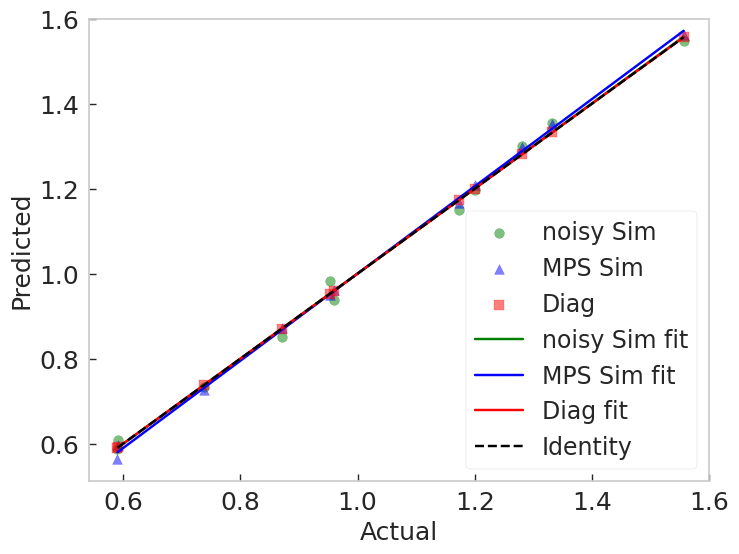

In [24]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=feature_sim_noisy_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # only for GPU
)
create_model_and_plot(s_sim_noisy, s_exact, s_sim_noiseless, is_qpu=False)

In [25]:
# これと同じ予測を上のセルでは行なっている
# best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort=sort)
# s_sim_noisy.plot_model(best_sim_noisy, plot="error")

### Regression with features from QPU

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(55, 25)"
4,Transformed data shape,"(55, 24)"
5,Transformed train set shape,"(44, 24)"
6,Transformed test set shape,"(11, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0389,0.0021,0.0458,0.9767,0.0225,0.0400


(QPU) 12 qubits: BayesianRidge, R2 = 9.77e-01, MSE = 2.10e-03


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0102,0.0002,0.0129,0.9982,0.0070,0.0115


(Sim, noise free) 12 qubits: BayesianRidge, R2 = 9.98e-01, MSE = 1.66e-04


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


(Exact) 12 qubits: LinearRegression, R2 = 1.00e+00, MSE = 1.47e-10
(QPU) Best fit line (y = 9.08e-01x + 8.98e-02)
(Sim, noise free) Best fit line (y = 1.03e+00x - 2.62e-02)
(Exact) Best fit line (y = 1.00e+00x - 1.80e-05)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

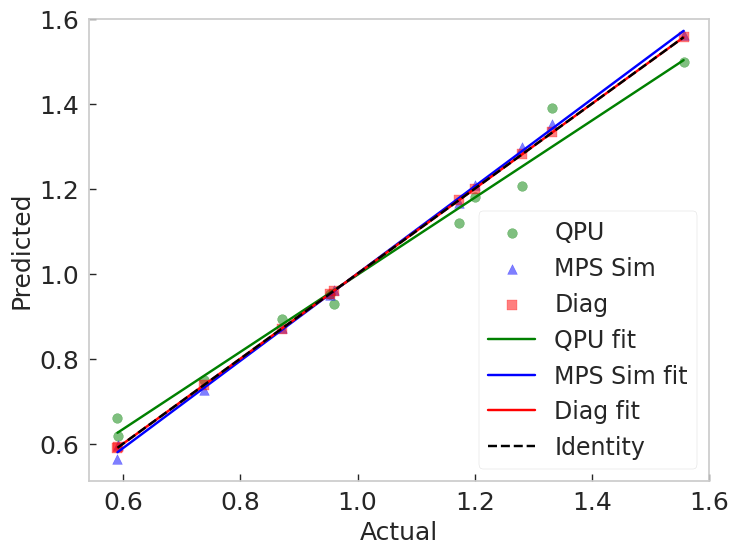

In [26]:
s_qpu = RegressionExperiment()
s_qpu.setup(
    data=feature_qpu_df,
    target="expected_value",
    ignore_features=["sample_id"],
    train_size=train_size,
    session_id=session_id,
    use_gpu=True,  # only for GPU
)
if n_qubits <= 12:
    create_model_and_plot(s_qpu, s_exact, s_sim_noiseless, is_qpu=True)
else:
    create_model_and_plot(
        s_qpu,
        exact_experiment=None,
        sim_noiseless_experiment=s_sim_noiseless,
        is_qpu=True,
    )

In [ ]:
# これと同じ予測を上のセルでは行なっている
# best_nmit = s_nmit.compare_models(turbo=True, sort=sort)
# s_nmit.plot_model(best_nmit, plot="error")